In [3]:
import math 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib_inline 
import csv

In [2]:
def f(x):
    formula = 3*x**2 - 4*x +5
    return formula

In [3]:
f(3.0)

20.0

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

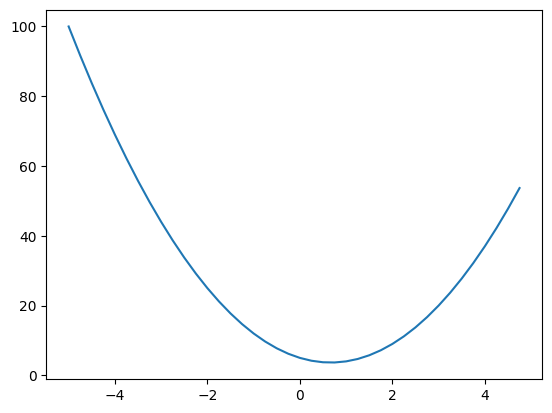

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)
ys


In [5]:
h = 0.00000001
x = 3.0
(f(x+h)-f(x))/h

14.00000009255109

In [6]:
h = 0.00001

a = 2
b =-3
c = 10

d1 = a*b +c
b +=h
d2 = a*b+c

print("d1",d1)
print("d2",d2)
print("slope",(d2-d1)/h)

d1 4
d2 4.00002
slope 2.0000000000131024


In [97]:
class value:

    def __init__(self,data,_children=(),_op="",label =""):
        self.data= data
        self.prev = set(_children)
        self._op =_op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    
    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, value) else value(other)
        out = value(self.data + other.data,(self,other),"+")

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self,other):
        other = other if isinstance(other,value) else value(other)
        out = value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self,other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1

    
    def __rmul__(self,other):
        return self*other
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting float for now"
        out = value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other*(self.data** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self,other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = value(t,(self,), "tanh")
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out
    
    def backward(self):
        list = []
        visited = set()
        def topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    topo(child)
                list.append(v)
        topo(self)
        self.grad = 1.0
        for node in reversed(list):
            node._backward()

In [84]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

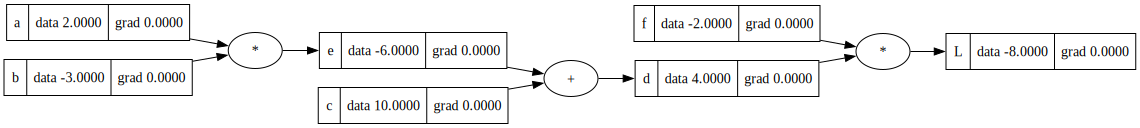

In [126]:
draw_dot(L)

In [92]:

a.data += 0.01 * a.grad
b.data += 0.01 *b.grad
c.data += 0.01 *c.grad
f.data += 0.01 *f.grad

e =a*b
d = e+c
l = d*f

print(L.data)

-8.0


In [87]:
def lal():
    h = 0.001


    a = value(2.0,label="a")
    b = value(-3.0,label="b")
    c = value(10.0,label="c")
    e = a*b ; e.label="e"
    d = e + c; d.label="d"
    f = value(-2.0, label="f")
    l = d * f; L.label="L"
    L1 = l.data

    a = value(2.0,label="a")
    b = value(-3.0,label="b")
    b.data+=h
    c = value(10.0,label="c")
    e = a*b ; e.label="e"
    d = e + c; d.label="d"
    f = value(-2.0, label="f")
    l = d * f; L.label="L"
    L2 = l.data

    print((L2-L1)/h)
lal() 

-3.9999999999995595


In [95]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label="o"


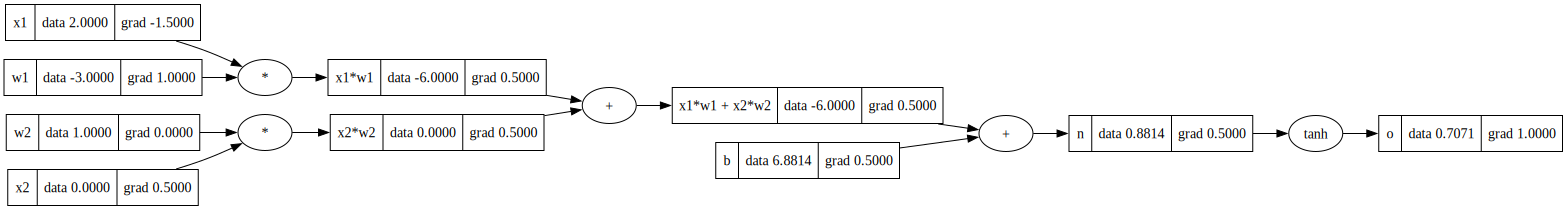

In [96]:
o.backward()
draw_dot(o)

In [74]:
a = value(2.0)
b = value(3.0)

c = a -b
c.data

-1.0

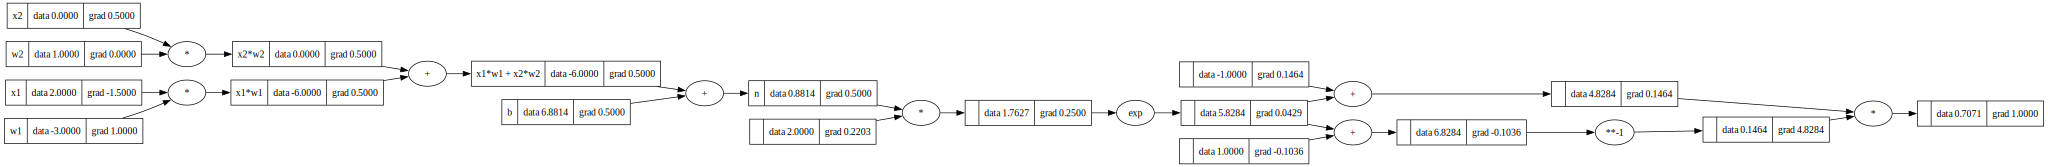

In [98]:


x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o = o; label="o"
o.backward()
draw_dot(o)
        
